Решение задачи с помощью алгоритмов классического машинного обучения

## Импорты

In [1]:
import os
import typing
from tqdm import tqdm

import pandas as pd
import json

import numpy as np

In [2]:
from datetime import datetime

## Классы

In [3]:
class DataFilePaths:
    def __init__(self, testcase_path: str):
        self.testcase_path = testcase_path
        
    def localization(self):
        return os.path.join(self.testcase_path, 'localization.csv')
    
    def control(self):
        return os.path.join(self.testcase_path, 'control.csv')
    
    def metadata(self):
        return os.path.join(self.testcase_path, 'metadata.json')
    
    # exists only for test_dataset
    def requested_stamps(self):
        return os.path.join(self.testcase_path, 'requested_stamps.csv') 

## Функции

In [4]:
# Load all ids of a dataset

def read_testcase_ids(dataset_path: str):
    ids = [int(case_id) for case_id in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, case_id))]
    return ids

In [5]:
def read_localization(localization_path: str):
    return pd.read_csv(localization_path)

def read_control(control_path):
    return pd.read_csv(control_path)

def read_metadata(metadata_path: str):
    with open(metadata_path, 'r') as f:
        data = json.load(f)
    return data

def read_requested_stamps(requested_stamps_path: str):
    return pd.read_csv(requested_stamps_path)
    
def read_testcase(dataset_path: str, testcase_id: str, is_test: bool = False):
    testcase_path = os.path.join(dataset_path, str(testcase_id))
    data_file_paths = DataFilePaths(testcase_path)
    
    testcase_data = {}
    testcase_data['localization'] = read_localization(data_file_paths.localization())
    testcase_data['control'] = read_control(data_file_paths.control())
    testcase_data['metadata'] = read_metadata(data_file_paths.metadata())
    if is_test:
        testcase_data['requested_stamps'] = read_requested_stamps(data_file_paths.requested_stamps())
        
    return testcase_data

In [6]:
def read_testcases(dataset_path: str, is_test: bool = False,
                   testcase_ids: typing.Iterable[int] = None,
                   amount: int | None = None):
    result = {}
    if testcase_ids is None:
        if amount is None:
            testcase_ids = read_testcase_ids(dataset_path)
        else:
            testcase_ids = read_testcase_ids(dataset_path)[:amount]
    
    for testcase_id in tqdm(testcase_ids):
        testcase = read_testcase(dataset_path, testcase_id, is_test=is_test)
        result[testcase_id] = testcase
    return result

## Данные

In [7]:
# Пути до датасетов

ROOT_DATA_FOLDER = "../"

TRAIN_DATASET_PATH = os.path.join(ROOT_DATA_FOLDER, "YaCupTrain")
TEST_DATASET_PATH = os.path.join(ROOT_DATA_FOLDER, "YaCupTest")

In [8]:
# Чтение train dataset

train_dataset = read_testcases(TRAIN_DATASET_PATH, amount=5000)
len(train_dataset)

 10%|▉         | 486/5000 [00:07<01:07, 66.50it/s] 


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [63]:
# Чтение test dataset

test_dataset = read_testcases(TEST_DATASET_PATH, is_test=True, amount=None)
len(test_dataset)

100%|██████████| 8000/8000 [01:19<00:00, 100.15it/s]


8000

## Сборка всех фич в один датасет

In [9]:
# Функция для конвертации даты в время года (зима, весна, лето, осень)
def get_season(date):
    month = date.month
    if month in (12, 1, 2):
        return 'зима'
    elif month in (3, 4, 5):
        return 'весна'
    elif month in (6, 7, 8):
        return 'лето'
    else:
        return 'осень'

In [68]:
# Функция для записи создания датасета с указанием дополнительных фич + все id сцен собираются в один датасет
def prepare_train_dataset(dataset):
    # Создание общего датасета
    all_data = {"case_id": [], "season": [], "vehicle_model": [], "vehicle_model_modification": [],
                "stamp_ns": [], "x": [], "y": [], "z": [],
                "roll": [], "pitch": [], "yaw": [], "x_shift": [], "y_shift": [],
                "z_shift": [], "roll_shift": [], "pitch_shift": [], "yaw_shift": [],
                }

    for key in tqdm(dataset.keys()):
        # Данные для case_id
        key = int(key)
        cur = dataset[key]['localization']
        key_vals = [key] * len(cur)
        
        # Сдвиг по осям X, Y, Z
        x_shifts = np.ediff1d(cur['x'].values, to_begin=0)
        y_shifts = np.ediff1d(cur['y'].values, to_begin=0)
        z_shifts = np.ediff1d(cur['z'].values, to_begin=0)
        # Изменение угла поворта по осям roll, pitch, yaw
        roll_shifts = np.ediff1d(cur['roll'].values, to_begin=0)
        pitch_shifts = np.ediff1d(cur['pitch'].values, to_begin=0)
        yaw_shifts = np.ediff1d(cur['yaw'].values, to_begin=0)


        # Получение метаданных сцены
        meta = train_dataset[key]['metadata']
        ride_date = datetime.strptime(meta['ride_date'], '%Y-%m-%d')
        # Вычисление сезона года из даты
        ride_date = get_season(ride_date)
        ride_date_vals = [ride_date] * len(cur)
        vehicle_model = int(meta['vehicle_model'])
        vehicle_model_vals = [vehicle_model] * len(cur)
        vehicle_model_modification = int(meta['vehicle_model_modification'])
        vehicle_model_modification_vals = [vehicle_model_modification] * len(cur)
        
        all_data['case_id'].extend(key_vals)
        all_data['x_shift'].extend(x_shifts)
        all_data['y_shift'].extend(y_shifts)
        all_data['z_shift'].extend(z_shifts)
        all_data['roll_shift'].extend(roll_shifts)
        all_data['pitch_shift'].extend(pitch_shifts)
        all_data['yaw_shift'].extend(yaw_shifts)
        all_data['season'].extend(ride_date_vals)
        all_data['vehicle_model'].extend(vehicle_model_vals)
        all_data['vehicle_model_modification'].extend(vehicle_model_modification_vals)
        all_data['x'].extend(cur['x'])
        all_data['y'].extend(cur['y'])
        all_data['z'].extend(cur['z'])
        all_data['stamp_ns'].extend(cur['stamp_ns'])
        all_data['roll'].extend(cur['roll'])
        all_data['pitch'].extend(cur['pitch'])
        all_data['yaw'].extend(cur['yaw'])
            
    return all_data

In [65]:
# Функция для записи создания датасета с указанием дополнительных фич + все id сцен собираются в один датасет
def prepare_test_dataset(dataset):
    # Создание общего датасета
    all_data = {"case_id": [], "stamp_ns": [], "season": [],
                "vehicle_model": [], "vehicle_model_modification": []}
    for key in tqdm(dataset.keys()):
        # Данные для case_id
        cur = dataset[key]['requested_stamps']
        key = int(key)
        key_vals = [key] * len(cur)

        # Получение метаданных сцены
        meta = dataset[key]['metadata']
        ride_date = datetime.strptime(meta['ride_date'], '%Y-%m-%d')
        # Вычисление сезона года из даты
        ride_date = get_season(ride_date)
        ride_date_vals = [ride_date] * len(cur)
        vehicle_model = int(meta['vehicle_model'])
        vehicle_model_vals = [vehicle_model] * len(cur)
        vehicle_model_modification = int(meta['vehicle_model_modification'])
        vehicle_model_modification_vals = [vehicle_model_modification] * len(cur)
    
        all_data['case_id'].extend(key_vals)
        all_data['stamp_ns'].extend(cur['stamp_ns'])
        all_data['season'].extend(ride_date_vals)
        all_data['vehicle_model'].extend(vehicle_model_vals)
        all_data['vehicle_model_modification'].extend(vehicle_model_modification_vals)
    
    return all_data

### Создание новых датасетов с вынесением всей интересной информации в одной таблице

In [72]:
# Получение общего train dataset
train_dict = prepare_train_dataset(train_dataset)

df_train = pd.DataFrame(columns=['case_id', 'season', 'vehicle_model', 'vehicle_model_modification',
                                 'stamp_ns', 'x', 'y', 'z', 'roll', 'pitch', 'yaw', 'x_shift', 'y_shift',
                                 'z_shift', 'roll_shift', 'pitch_shift', 'yaw_shift'],
                        data=train_dict)

100%|██████████| 5000/5000 [00:23<00:00, 213.18it/s]


In [66]:
# Получение общего test dataset
test_dict = prepare_test_dataset(test_dataset)

# Сохранение данных в DataFrame
df_test = pd.DataFrame(columns=['case_id', 'season', 'vehicle_model', 'vehicle_model_modification',
                                'stamp_ns', 'x', 'y', 'yaw'],
                       data=test_dict)

100%|██████████| 8000/8000 [00:01<00:00, 7639.86it/s]


In [80]:
# Итоговые датасеты для обучения и предсказания
print("Датасет для обучения:")
print(df_train.head())
print("=============================================")
print("Датасет для предсказания:")
print(df_test.head())

Датасет для обучения:
   case_id season  vehicle_model  vehicle_model_modification   stamp_ns  \
0        0  весна              0                           0          0   
1        0  весна              0                           0   39989868   
2        0  весна              0                           0   79819886   
3        0  весна              0                           0  125154671   
4        0  весна              0                           0  159636974   

             x             y          z      roll     pitch       yaw  \
0 -4292.313705 -14527.266319  66.043314  0.003926 -0.054198 -1.936810   
1 -4292.489928 -14527.726083  66.070022  0.003702 -0.054172 -1.936858   
2 -4292.662729 -14528.183063  66.090338  0.002404 -0.054628 -1.936827   
3 -4292.862032 -14528.702952  66.120814  0.002709 -0.054559 -1.936894   
4 -4293.011898 -14529.097871  66.138226  0.003264 -0.053668 -1.936876   

    x_shift   y_shift   z_shift  roll_shift  pitch_shift  yaw_shift  
0  0.000000  0.000

In [81]:
# Запись полученного df_train в csv файл
df_train.to_csv("df_train.csv", header=True, index=False)

In [82]:
# Запись полученного df_test в csv файл
df_test.to_csv("df_test.csv", header=True, index=False)

## Обучение моделей

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [21]:
# Чтение датасетов
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")

# Удаление лишних столбцов
df_train = df_train[['case_id', 'season', 'vehicle_model',
                     'vehicle_model_modification', 'stamp_ns',
                     'x', 'y', 'yaw']]

In [25]:
# Данные для обучения
X = df_train.drop(['x', 'y', 'yaw'], axis=1)
y_1 = df_train[['x']]
y_2 = df_train[['y']]
y_3 = df_train[['yaw']]

### Предсказание 'X'

In [43]:
# Разделение данных на обучающие и тестовые
# 1-ая модель
X_train, X_valid, y_train, y_valid = train_test_split(X, y_1, test_size=0.25, random_state=2024)

In [44]:
# Числовые переменные
X_nums = ['stamp_ns']
# Категориальные переменные
cat_features = ['case_id', 'season', 'vehicle_model', 'vehicle_model_modification']
# Зависимая переменная
y_col = ['x']

In [45]:
# Создание модели №1 для предсказания 'X'
model_1 = CatBoostRegressor(random_seed=2024, verbose=1, task_type="GPU",
                            cat_features=cat_features, loss_function="RMSE",
                            early_stopping_rounds=100, iterations=6000,
                            learning_rate=0.1)

In [46]:
# Обучение модели №1
model_1.fit(X_train, y_train, eval_set=(X_valid, y_valid))

0:	learn: 7105.4614597	test: 7100.8326443	best: 7100.8326443 (0)	total: 672ms	remaining: 44m 47s
100:	learn: 5668.8862233	test: 5665.2636596	best: 5665.2636596 (100)	total: 43.4s	remaining: 27m 56s
200:	learn: 5603.9768263	test: 5600.6395560	best: 5600.6395560 (200)	total: 1m 19s	remaining: 25m 7s
300:	learn: 5557.4240306	test: 5554.8569878	best: 5554.8569878 (300)	total: 1m 55s	remaining: 23m 37s
400:	learn: 5513.6322327	test: 5510.8595067	best: 5510.8595067 (400)	total: 2m 31s	remaining: 22m 40s
500:	learn: 5478.3525222	test: 5475.0726699	best: 5475.0726699 (500)	total: 3m 7s	remaining: 21m 51s
600:	learn: 5449.1215683	test: 5445.7030867	best: 5445.7030867 (600)	total: 3m 43s	remaining: 21m 5s
700:	learn: 5419.4087267	test: 5416.5322193	best: 5416.5322193 (700)	total: 4m 22s	remaining: 20m 34s
800:	learn: 5388.3330945	test: 5385.3621812	best: 5385.3621812 (800)	total: 4m 59s	remaining: 19m 55s
900:	learn: 5351.4863516	test: 5348.3957989	best: 5348.3957989 (900)	total: 5m 37s	remainin

In [48]:
print(f"Лучшее качество модели получено на {model_1.best_iteration_} итерации")
print(f"RMSE на обучающих данных = {model_1.best_score_['learn']['RMSE']:.2f}")
print(f"RMSE на валидационных данных = {model_1.best_score_['validation']['RMSE']:.2f}")

Лучшее качество модели получено на 3999 итерации
RMSE на обучающих данных = 4311.70
RMSE на валидационных данных = 4307.68


In [53]:
# Метрики качества модели
preds = model_1.predict(X_valid)
result = r2_score(y_valid, preds)

print(f"R2 CatBoost модели = {result:.2f}")

# Точность модели с помощью расчета R2 метрики
preds = model_1.predict(X_valid)
result = mean_absolute_error(y_valid, preds)

print(f"MAE модели = {result:.2f}")

R2 CatBoost модели = 0.64
MAE модели = 2575.20


#### Сохранение и загрузка модели

In [51]:
model_1.save_model("../models/model_1.cbm")

In [52]:
model_1 = CatBoostRegressor().load_model("../models/model_1.cbm")

#### График обучения модели

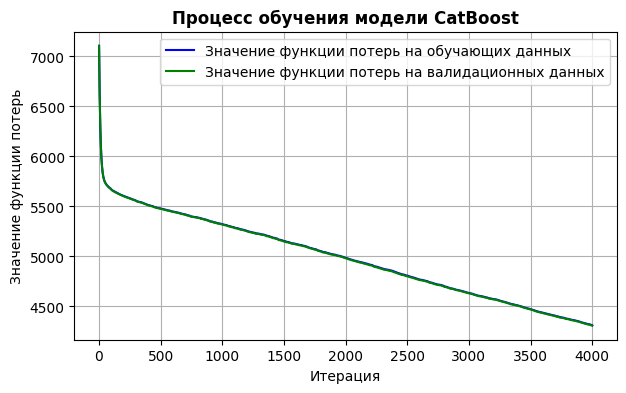

In [47]:
# Информация о значениях RMSE на обучающих данных и валидационных
evals_result = model.get_evals_result()
train_loss = evals_result['learn']["RMSE"]
test_loss = evals_result['validation']["RMSE"]


# Построение графика обучения модели CatBoost
iterations = np.arange(1, len(train_loss) + 1)
 
plt.figure(figsize=(7, 4))
plt.plot(iterations, train_loss, label='Значение функции потерь на обучающих данных', color='blue')
plt.plot(iterations, test_loss, label='Значение функции потерь на валидационных данных', color='green')
plt.xlabel('Итерация')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения модели CatBoost', fontweight="bold")
plt.legend()
plt.grid()
# plt.savefig("../Images/Graphs/Training_Progress_CatBoost_Model_v2.png", dpi=199)
plt.show()

### Предсказание 'Y'

In [ ]:
# Разделение данных на обучающие и тестовые
# 2-ая модель
X_train, X_valid, y_train, y_valid = train_test_split(X, y_2, test_size=0.25, random_state=2024)

In [ ]:
# Числовые переменные
X_nums = ['stamp_ns']
# Категориальные переменные
cat_features = ['case_id', 'season', 'vehicle_model', 'vehicle_model_modification']
# Зависимая переменная
y_col = ['y']

In [ ]:
# Создание модели №1 для предсказания 'X'
model_2 = CatBoostRegressor(random_seed=2024, verbose=1, task_type="GPU",
                            cat_features=cat_features, loss_function="RMSE",
                            early_stopping_rounds=100, iterations=6000,
                            learning_rate=0.1)

In [ ]:
# Обучение модели №1
model_2.fit(X_train, y_train, eval_set=(X_valid, y_valid))

0:	learn: 7105.4614597	test: 7100.8326443	best: 7100.8326443 (0)	total: 672ms	remaining: 44m 47s
100:	learn: 5668.8862233	test: 5665.2636596	best: 5665.2636596 (100)	total: 43.4s	remaining: 27m 56s
200:	learn: 5603.9768263	test: 5600.6395560	best: 5600.6395560 (200)	total: 1m 19s	remaining: 25m 7s
300:	learn: 5557.4240306	test: 5554.8569878	best: 5554.8569878 (300)	total: 1m 55s	remaining: 23m 37s
400:	learn: 5513.6322327	test: 5510.8595067	best: 5510.8595067 (400)	total: 2m 31s	remaining: 22m 40s
500:	learn: 5478.3525222	test: 5475.0726699	best: 5475.0726699 (500)	total: 3m 7s	remaining: 21m 51s
600:	learn: 5449.1215683	test: 5445.7030867	best: 5445.7030867 (600)	total: 3m 43s	remaining: 21m 5s
700:	learn: 5419.4087267	test: 5416.5322193	best: 5416.5322193 (700)	total: 4m 22s	remaining: 20m 34s
800:	learn: 5388.3330945	test: 5385.3621812	best: 5385.3621812 (800)	total: 4m 59s	remaining: 19m 55s
900:	learn: 5351.4863516	test: 5348.3957989	best: 5348.3957989 (900)	total: 5m 37s	remainin

In [ ]:
print(f"Лучшее качество модели получено на {model_2.best_iteration_} итерации")
print(f"RMSE на обучающих данных = {model_2.best_score_['learn']['RMSE']:.2f}")
print(f"RMSE на валидационных данных = {model_2.best_score_['validation']['RMSE']:.2f}")

Лучшее качество модели получено на 3999 итерации
RMSE на обучающих данных = 4311.70
RMSE на валидационных данных = 4307.68


In [ ]:
# Метрики качества модели
preds = model_2.predict(X_valid)
result = r2_score(y_valid, preds)

print(f"R2 CatBoost модели = {result:.2f}")

# Точность модели с помощью расчета R2 метрики
preds = model_2.predict(X_valid)
result = mean_absolute_error(y_valid, preds)

print(f"MAE модели = {result:.2f}")

R2 CatBoost модели = 0.64
MAE модели = 2575.20


#### Сохранение и загрузка модели

In [ ]:
model_2.save_model("../models/model_2.cbm")

In [ ]:
model_2 = CatBoostRegressor().load_model("../models/model_2.cbm")

#### График обучения модели

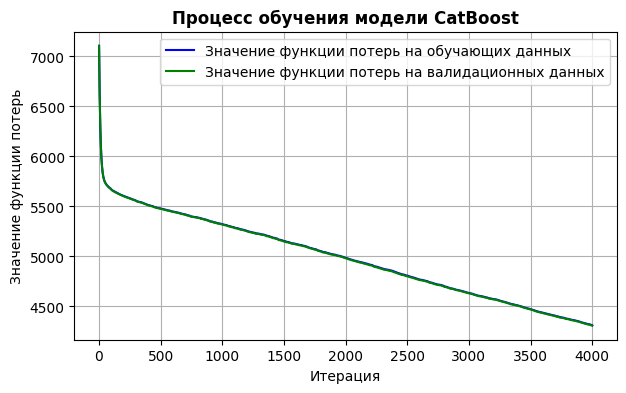

In [ ]:
# Информация о значениях RMSE на обучающих данных и валидационных
evals_result = model_2.get_evals_result()
train_loss = evals_result['learn']["RMSE"]
test_loss = evals_result['validation']["RMSE"]


# Построение графика обучения модели CatBoost
iterations = np.arange(1, len(train_loss) + 1)
 
plt.figure(figsize=(7, 4))
plt.plot(iterations, train_loss, label='Значение функции потерь на обучающих данных', color='blue')
plt.plot(iterations, test_loss, label='Значение функции потерь на валидационных данных', color='green')
plt.xlabel('Итерация')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения модели CatBoost', fontweight="bold")
plt.legend()
plt.grid()
# plt.savefig("../Images/Graphs/Training_Progress_CatBoost_Model_v2.png", dpi=199)
plt.show()